In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np 
import sklearn

In [4]:
file1 = pd.read_csv('/content/drive/MyDrive/filtered_binary_ENCODE_K562_80.csv', header = None)

In [5]:
file1[3].value_counts() # ~350k reads/protein

0    358411
1    350303
Name: 3, dtype: int64

In [6]:
# Subsample

file1 = file1.sample(n=100000, random_state=1)
file1[3].value_counts()

0    50439
1    49561
Name: 3, dtype: int64

In [7]:
file1[3].value_counts() #100989 and 99011
#file1[4].str.len().max() #432

0    50439
1    49561
Name: 3, dtype: int64

In [8]:
# One Hot Encoding and Padding functions

def onehote(seq):
    seq2=list()
    mapping = {"a":[1., 0., 0., 0.], "c": [0., 1., 0., 0.], "g": [0., 0., 1., 0.], "t":[0., 0., 0., 1.]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0., 0., 0., 0.]) 
    return np.array(seq2)


In [9]:
# One Hot Encoding: DNA Sequences [atgc] > array [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
ohe = []
for i in range(0,len(file1[4])):
    res = onehote(file1[4].iloc[i])
    ohe.append(res)
    

In [10]:
# Padding + reshaping X

from tensorflow.keras.preprocessing import sequence
X = sequence.pad_sequences(ohe,maxlen=432)  # shape: (100000, 432, 4)
X = X.reshape(X.shape[0], -1) # reshape: (100000, 1728)

Y = np.array(file1[3]) # shape: (100000,)

In [11]:
# Train and Test Split (80/20)

'''
Things to consider: 
1. test_size
2. shuffle
3. stratify
4. Stratifiedshufflesplit vs train_test_split
5. StratifiedKfold - used during cross validation (in future)
'''
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1, stratify = Y)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(80000, 1728) (80000,)
(20000, 1728) (20000,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Logistic Regression Training Accuracy:  0.750475
Model Performance 0.75205


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


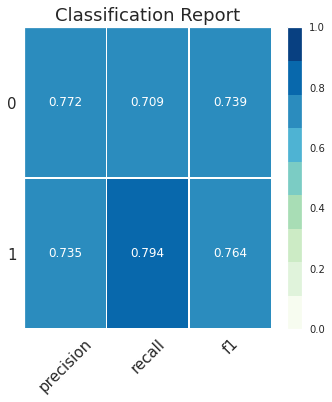

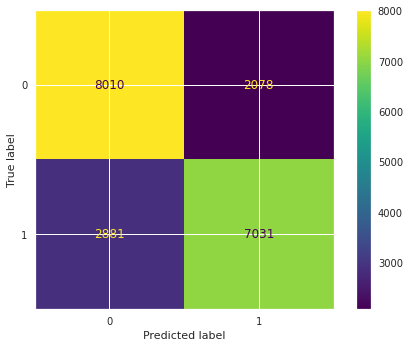

In [30]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, roc_curve, accuracy_score, auc, classification_report, plot_confusion_matrix, plot_roc_curve, precision_score, f1_score
from yellowbrick.classifier import ClassificationReport, discrimination_threshold, classification_report


lm = LogisticRegression(max_iter=2000, solver = 'saga', penalty = 'l1', C = 5, n_jobs = -1, random_state = 1)
lm.fit(X_train, Y_train)

# Train Model Accuracy
print('Logistic Regression Training Accuracy: ', lm.score(X_train, Y_train))

# Classification report

classes = [0,1]

fig = plt.gcf()
ax = plt.subplot(111)
visualizer = ClassificationReport(lm,classes=[0,1], size=(400,400),fontsize=15, cmap='GnBu', ax = ax)
ax.grid(False)
plt.title("Classification Report", fontsize=18)

visualizer.fit(X_train, Y_train)
print('Model Performance', visualizer.score(X_test, Y_test))
#visualizer.poof()

# Visualize confusion matrix

plot_confusion_matrix(lm, X_test, Y_test)
plt.show()

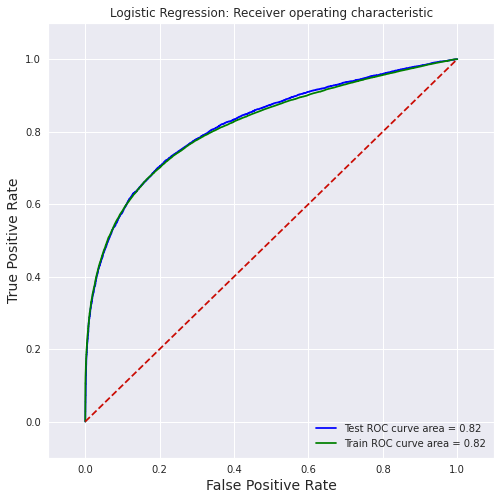

In [32]:
# ROC curve
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
preds_train = lm.predict(X_train)
 # calculate prediction probability
prob_train = np.squeeze(lm.predict_proba(X_train)[:,1].reshape(1,-1))
prob_test = np.squeeze(lm.predict_proba(X_test)[:,1].reshape(1,-1))
# false positive rate, true positive rate, thresholds
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, prob_test)
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_train, prob_train)
# auc score
auc1 = metrics.auc(fpr1, tpr1)
auc2 = metrics.auc(fpr2, tpr2)
plt.figure(figsize=(8,8))
# plot auc 
plt.plot(fpr1, tpr1, color='blue', label='Test ROC curve area = %0.2f'%auc1)
plt.plot(fpr2, tpr2, color='green', label='Train ROC curve area = %0.2f'%auc2)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='lower right')
plt.title('Logistic Regression: Receiver operating characteristic')
plt.show() 


Random Forest Classifier Training Accuracy:  0.8606625
Model Performance 0.72415


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


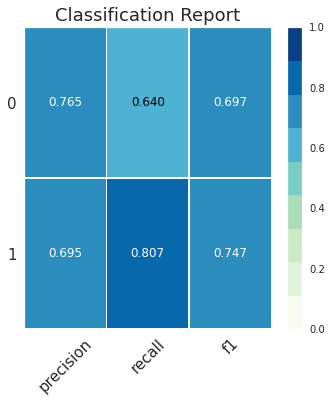

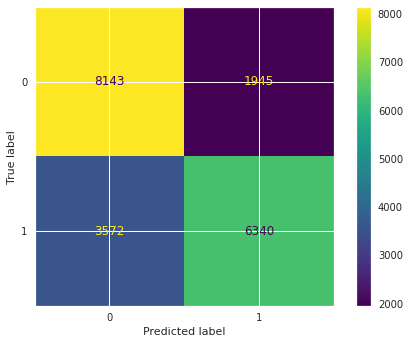

In [23]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 200, criterion = "gini", min_samples_leaf = 5, n_jobs = -1, random_state = 1)
forest.fit(X_train, Y_train)

print('Random Forest Classifier Training Accuracy: ', forest.score(X_train, Y_train))

# Classification report
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, roc_curve, accuracy_score, auc, classification_report, plot_confusion_matrix, plot_roc_curve, precision_score, f1_score
from yellowbrick.classifier import ClassificationReport, discrimination_threshold, classification_report

classes = [0,1]

fig = plt.gcf()
ax = plt.subplot(111)
visualizer = ClassificationReport(forest,classes=[0,1], size=(400,400),fontsize=15, cmap='GnBu', ax = ax)
ax.grid(False)
plt.title("Classification Report", fontsize=18)

visualizer.fit(X_train, Y_train)
print('Model Performance', visualizer.score(X_test, Y_test))

# Visualize confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(forest, X_test, Y_test)
plt.show()

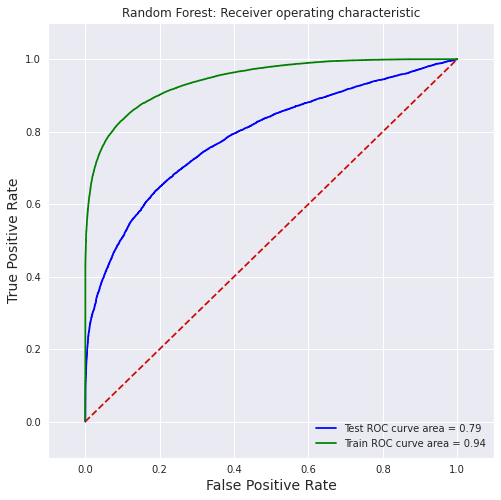

In [31]:
# ROC curve

import seaborn as sns
import sklearn.metrics as metrics
sns.set_style('darkgrid') 

sns.set_style('darkgrid')
preds_train = forest.predict(X_train)
 # calculate prediction probability
prob_train = np.squeeze(forest.predict_proba(X_train)[:,1].reshape(1,-1))
prob_test = np.squeeze(forest.predict_proba(X_test)[:,1].reshape(1,-1))
# false positive rate, true positive rate, thresholds
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, prob_test)
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_train, prob_train)
# auc score
auc1 = metrics.auc(fpr1, tpr1)
auc2 = metrics.auc(fpr2, tpr2)
plt.figure(figsize=(8,8))
# plot auc 
plt.plot(fpr1, tpr1, color='blue', label='Test ROC curve area = %0.2f'%auc1)
plt.plot(fpr2, tpr2, color='green', label='Train ROC curve area = %0.2f'%auc2)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='lower right')
plt.title('Random Forest: Receiver operating characteristic')
plt.show() 


In [62]:
# ROC optimum threshold
import numpy as np
# creating index
i = np.arange(len(tpr1))
# extracting roc values against different thresholds 
roc = pd.DataFrame({'fpr':fpr1, 'tpr':tpr1, 'tf':(tpr1-1+fpr1), 'thresholds':thresholds1}, index=i)
# top 5 best roc occurrences 
roc.iloc[(roc.tf-0).abs().argsort()[:10]] 

,fpr,tpr,tf,thresholds
148,0.302736,0.719330,0.022066,0.480000
149,0.302835,0.719330,0.022165,0.479857
150,0.302835,0.719532,0.022367,0.478121
151,0.303033,0.719835,0.022868,0.475000
147,0.274881,0.702179,-0.022940,0.481818
146,0.274881,0.702078,-0.023041,0.485000
152,0.303232,0.719835,0.023066,0.472000
145,0.274782,0.702078,-0.023140,0.486468
153,0.303232,0.719935,0.023167,0.471167
144,0.274683,0.701977,-0.023340,0.486667


In [1]:
# Hyoerparameter tuning attempt

model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [500,600,700,800],
            'criterion' : ['gini', 'entorpy'],
            'max_features' : ['sqrt', 'log2'],
            'min_samples_leaf' : [int(x) for x in np.linspace(2, 16, num = 2)],
            'max_depth' : [int(x) for x in np.linspace(10, 100, num = 4)]

        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='saga', penalty = 'l1'),
        'params': {
            'max_iter' : [int(x) for x in np.linspace(40, 200, num = 20)],
            'C': [5,10],
            'normalize': ['True','False']
        }
    }
}

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, Y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

NameError: ignored

In [ ]:
# Parameter scaling attempt
"""
# Requires too much RAM!!!
# With and without
#Feature Scaling: z = (x - u) / s
'''
Standardize features by removing the mean and scaling to unit variance.
with_mean = T
with_std = T
'''
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
"""